# Requirements

For Data Preparation:
- install ffmpeg (for ubuntu: https://trac.ffmpeg.org/wiki/CompilationGuide/Ubuntu)

For Creating Images and Annotations
- faster rcnn (Follow the instruction until you download pre-computed models: https://github.com/rbgirshick/rcnn)

# 1. Data Preparation

Start by creating videos (3-5 min) of each class object. This command below extracts n frames per second from each video and saves them into files named output_0001.png, output_0002.png, etc. Make sure to create a folder where output image files get saved.


Command: <strong> ffmpeg -i input.mov -r n output_%04d.png </strong>
In this commands below, our videos are saved in /home/ai2-jedi/Documents/code/Asia_cans/,
captured images will be saved in /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/,
and final dataset will be saved in /home/ai2-jedi/data/SmartCooler_Asia/

In [1]:
#%%capture # suppressing printing for this cell

# Run this for each class
! mkdir /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda
! ffmpeg -i /home/ai2-jedi/Documents/code/Asia_cans/marinda.mp4 -r 8 /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda/mirinda%03d.jpg

! mkdir /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/schweppes
! ffmpeg -i /home/ai2-jedi/Documents/code/Asia_cans/schweppes.mp4 -r 8 /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/schweppes/schweppes%03d.jpg

ffmpeg version N-79139-gde1a0d4 Copyright (c) 2000-2016 the FFmpeg developers
  built with gcc 4.8 (Ubuntu 4.8.4-2ubuntu1~14.04.1)
  configuration: --extra-libs=-ldl --prefix=/opt/ffmpeg --mandir=/usr/share/man --enable-avresample --disable-debug --enable-nonfree --enable-gpl --enable-version3 --enable-libopencore-amrnb --enable-libopencore-amrwb --disable-decoder=amrnb --disable-decoder=amrwb --enable-libpulse --enable-libfreetype --enable-gnutls --enable-libx264 --enable-libx265 --enable-libfdk-aac --enable-libvorbis --enable-libmp3lame --enable-libopus --enable-libvpx --enable-libspeex --enable-libass --enable-avisynth --enable-libsoxr --enable-libxvid --enable-libvidstab
  libavutil      55. 19.100 / 55. 19.100
  libavcodec     57. 30.100 / 57. 30.100
  libavformat    57. 29.101 / 57. 29.101
  libavdevice    57.  0.101 / 57.  0.101
  libavfilter     6. 40.102 /  6. 40.102
  libavresample   3.  0.  0 /  3.  0.  0
  libswscale      4.  0.100 /  4.  0.100
  libswresample   2.  0.101 /

# 2. Creating Images and Annotations

Our approach uses an existing model trained for PASCAL VOC datasets which has 20 classes of object. One of the 20 classes is bottle. For this code to recognize brands on cans, we use the model to recognize bottle and use only images that have a "bottle" recognized.

In [2]:
# This is the classes of images we have created from videos
! ls /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/

coke	  dietdrpepper	mirinda       pepsi	 sunkist
cokezero  dietpepsi	mountaindew   schweppes
dietcoke  drpepper	multiplecans  sprite


In [3]:
%%capture
! mkdir /home/ai2-jedi/data/SmartCooler_Asia
! mkdir /home/ai2-jedi/data/SmartCooler_Asia/Annotations
! mkdir /home/ai2-jedi/data/SmartCooler_Asia/ImageSets
! mkdir /home/ai2-jedi/data/SmartCooler_Asia/ImageSets/Main
! mkdir /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages

# copy captured images into the dataset folder
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/schweppes/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/coke/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/cokezero/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/dietcoke/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/dietdrpepper/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/dietpepsi/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/drpepper/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mountaindew/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/pepsi/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/sprite/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/
! cp /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/sunkist/* /home/ai2-jedi/data/SmartCooler_Asia/JPEGImages/

In [4]:
# faster RCNN related
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from selectivesearch import selective_search

# supplemental
from utils.timer import Timer
from scipy.spatial import distance
from scipy import misc
from math import sqrt
from PIL import Image
from cStringIO import StringIO
from sklearn.externals import joblib

from datetime import datetime
import caffe, os, sys, cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import xml.etree.cElementTree as ET
import argparse
import base64
import skimage
import scipy
import json
import operator
import logging

from app import app # Don't delete this. This makes it run way faster

%matplotlib inline

/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
#pics_dir = '/home/ai2-jedi/data/SmartCooler/JPEGImages'
imgs_by_class_dir = '/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/'
final_dataset_dir = '/home/ai2-jedi/data/SmartCooler_Asia/'

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('VGG16', 'VGG16_faster_rcnn_final.caffemodel'),
        'zf': ('ZF', 'ZF_faster_rcnn_final.caffemodel'),
        'vgg16_finetune': ('VGG16', 'vgg16_faster_rcnn_iter_100000.caffemodel'),
        'vgg16_finetune2': ('VGG16', 'vgg16_faster_rcnn_iter_2000.caffemodel')}



In [6]:
# Helper functions
def saveXML(image_dir,folder,bbox,file_name):
    """ Create an annotation in XML per image. """ 
    if bbox == []:
        #print 'No XML created for ' + image_dir
        return
    img = cv2.imread(image_dir)
    img = cv2.cvtColor(img, cv2.cv.CV_BGR2RGB)
    candidates = list()
    img_shape = img.shape
    candidates.append(img.shape)
    for box in bbox:
        x = box[0]
        y = box[1]
        x2 = box[2]
        y2 = box[3]
        cls = folder
        region = (x,y,x2,y2,cls)
        candidates.append(region)
    
    root = ET.Element("annotation")
    
    folder = ET.SubElement(root, "folder")
    folder.text = "smartcooler"
    
    filename = ET.SubElement(root, "filename")
    filename.text = str(file_name)
    
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(candidates[0][1])
    ET.SubElement(size, "height").text = str(candidates[0][0])
    ET.SubElement(size, "depth").text = str(candidates[0][2])
    
    seg = ET.SubElement(root, "segmented")
    seg.text = '0'
    
    for item in candidates[1:]:
        obj = ET.SubElement(root, "object")
        ET.SubElement(obj, "name").text = str(item[4])
        ET.SubElement(obj, "pose").text = 'Unspecified'
        ET.SubElement(obj, "truncated").text = '0'
        ET.SubElement(obj, "difficult").text = '0'
        
        bbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bbox, "xmin").text = str(item[0])
        ET.SubElement(bbox, "ymin").text = str(item[1])
        ET.SubElement(bbox, "xmax").text = str(item[2])
        ET.SubElement(bbox, "ymax").text = str(item[3])

    tree = ET.ElementTree(root)
    os.chdir(final_dataset_dir + 'Annotations')
    index = file_name.find(".")
    fileToWrite = file_name[:index] + ".xml"
    tree.write(fileToWrite)
    
def print_bbox(filename, im, class_name, dets, thresh):
    """ Print detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if class_name == 'bottle':
        if len(inds) == 0:
            return
        for i in inds:
            bbox = dets[i, :4]
            score = dets[i, -1]
            bboxes.append(bbox)
            classes.append(class_name)
            scores.append(score)
            #print '{filename: %s, class: %s, bbox: %s, score: %s}' % (filename, class_name, bbox, score)

In [7]:
def demo(net, image_dir):
    """ Detect object classes in an image using pre-computed object proposals. """
    im = cv2.imread(image_dir)
    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    #print ('Detection took {:.3f}s for '
    #       '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.6
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        #vis_detections(im, cls, dets, thresh=CONF_THRESH)
        print_bbox(image_dir, im, cls, dets, thresh=CONF_THRESH)
        #saveXML(image_name, cls, dets, thresh=CONF_THRESH)       

In [8]:
# Main script to call each image and create annotation

cfg.TEST.HAS_RPN = True  # Use RPN for proposals
prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16'][0],
                       'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')
caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                          NETS['vgg16'][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))

net = caffe.Net(prototxt, caffemodel, caffe.TEST)
print '\n\nLoaded network {:s}'.format(caffemodel)



Loaded network /home/ai2-jedi/Documents/code/smartcooler_brand_recognition/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel


In [9]:
for f in os.listdir(imgs_by_class_dir):
    if f != 'multiplecans':
        can_folder = imgs_by_class_dir + f
        print can_folder
        for image in os.listdir(can_folder):
            image_dir = can_folder + "/" + image
            bboxes = []
            classes = []
            scores = []
            demo(net, image_dir)
            saveXML(image_dir,f,bboxes,image)

/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/dietcoke
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/cokezero
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/coke
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/sunkist
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mountaindew
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/pepsi
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/schweppes
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/dietpepsi
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/dietdrpepper
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/drpepper
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/sprite


In [11]:
# Checking how many images/annotations we got for each class
counters = {}
for name in os.listdir(imgs_by_class_dir):
    counters[name] = 0

for filename in os.listdir(final_dataset_dir + 'Annotations'):
    for name in counters:
        if name == filename[:-7]:
            counters[name] += 1
            break
            
print counters

{'cokezero': 43, 'sunkist': 66, 'dietcoke': 48, 'sprite': 129, 'multiplecans': 0, 'coke': 72, 'dietpepsi': 18, 'drpepper': 90, 'mirinda': 91, 'mountaindew': 62, 'pepsi': 49, 'schweppes': 49, 'dietdrpepper': 31}


In [12]:
# Removes the images that had no objects identified within them thus no .xml file
train_imgs_dir = final_dataset_dir + 'JPEGImages/'
for img in os.listdir(train_imgs_dir):
    index = img.find(".")
    name = img[:index] + '.xml'
    if name not in os.listdir(final_dataset_dir + 'Annotations/'):
        os.chdir(train_imgs_dir)
        os.remove(img)
        print "Removed " + str(img)

Removed sprite099.jpg
Removed pepsi288.jpg
Removed pepsi131.jpg
Removed drpepper303.jpg
Removed dietpepsi415.jpg
Removed sunkist476.jpg
Removed mirinda123.jpg
Removed sunkist477.jpg
Removed coke019.jpg
Removed dietdrpepper362.jpg
Removed drpepper158.jpg
Removed pepsi231.jpg
Removed dietpepsi285.jpg
Removed dietdrpepper313.jpg
Removed pepsi033.jpg
Removed drpepper247.jpg
Removed sprite113.jpg
Removed coke029.jpg
Removed pepsi327.jpg
Removed dietdrpepper249.jpg
Removed sprite160.jpg
Removed sprite184.jpg
Removed sunkist479.jpg
Removed dietpepsi206.jpg
Removed cokezero005.jpg
Removed coke401.jpg
Removed drpepper265.jpg
Removed coke087.jpg
Removed cokezero060.jpg
Removed pepsi050.jpg
Removed dietdrpepper395.jpg
Removed sprite359.jpg
Removed pepsi170.jpg
Removed sprite257.jpg
Removed sprite011.jpg
Removed drpepper245.jpg
Removed mirinda182.jpg
Removed drpepper321.jpg
Removed mountaindew341.jpg
Removed schweppes098.jpg
Removed sprite273.jpg
Removed mountaindew330.jpg
Removed dietcoke497.jpg


In [13]:
# Create the train.txt file for all the images that have annotations
annotations = os.listdir(final_dataset_dir + 'Annotations/')
trainFile = open(final_dataset_dir + 'ImageSets/Main/train.txt',"w")
for file_name in annotations:
    index = file_name.find(".")
    name = file_name[:index]
    trainFile.write(name + "\n")
trainFile.close()

# Fine Tuning Existing Models using the New Data

We have to modify several files in py-faster-rcnn package.

##### 1. experiments/scripts/faster_rcnn_end2end.sh

Add these lines in the block of cases (starting in line 25):

Change ITERS number to run more or less iterations

Scroll down to the line that calls train_net.py.

Change the directory of solver.prototxt and initial weights (pre-trained model) files that you want to use.

If you are using the default faster rcnn model, go to models > pascal_voc > VGG16, and copy faster_rcnn_end2end folder which has solver.prototxt, train.prototxt, and test.prototxt.

##### 2. lib/datasets/imagenet_factory.py
In the line 18, change the name variable to reflect what you called TRAIN_IMDB in the previous step.

For example:

##### 3. solver.prototxt

Make sure the train_net is pointing to the correct train.prototxt file.

Change snapshot_prefix to what you want to name the snapshots of the trainig

##### 4. train.prototxt & test.prototxt

If you copied a default one from faster_rcnn:
- search 21, change all of them to your number of classes + 1
- search 84, change all of them to (your number of classes + 1) * 4

##### 5. lib/datasets/imagenet.py
In the init function, change the first line to:

##### 6. lib/fast-rcnn/config.py

Change SNAPSHOT_ITERS to how often you want to save the snapshots

The code above changed:
- function inputs: removed 'year'
- changed the output folder name: it will save the output model to output/faster_rcnn_end2end/smartcooler_china_train folder
- devkit_path: the directory where you created SmartCooler_Asia in the previous steps
- data_path: devkit_path + the name of folder
- classes: names of cans you provided in the xml annotation files

##### Finally running the training script!

In terminal, inside of py-faster-rcnn folder, run the command below to start the training on GPU 1:
> ./experiments/scripts/faster_rcnn_end2end.sh 1 VGG16 smartcooler_china

The snapshots and outputs will be saved in the output/faster_rcnn_end2end/smartcooler_china_train folder.

The log files will be saved in experiments/logs folder.

# Testing the Output

Copy the output model to data/faster_rcnn_models folder

Put the image you want to try to data/demo folder

In [16]:
CLASSES = ('__background__',
           'coke cropped', 'drpepper cropped', 'dietpepsi cropped',
           'dietcoke cropped', 'pepsi cropped', 'dietdrpepper cropped',
           'mountaindew cropped', 'cokezero cropped', 'sprite cropped',
           'sunkist cropped', 'marinda cropped', 'schwepps cropped')

# Classes should be the class names in the xml files

#CLASSES = ('__background__',
#                 'coke', 'drpepper', 'dietpepsi',
#                 'dietcoke', 'pepsi', 'dietdrpepper',
#                 'mountaindew', 'cokezero', 'sprite',
#                 'sunkist', 'mirinda', 'schweppes')


NETS = {'vgg16': ('VGG16',
                  'VGG16_faster_rcnn_final.caffemodel'),
        'zf': ('ZF',
                  'ZF_faster_rcnn_final.caffemodel'),
        
        'vgg16_finetune_LAC': ('VGG16',
                'vgg16_faster_rcnn_iter_50000_LAC.caffemodel'),
        
        'vgg16_finetune_LACC': ('VGG16',
                'vgg16_faster_rcnn_iter_5000_LACC.caffemodel'),
        
        'vgg16_finetune_L': ('VGG16',
                'vgg16_faster_rcnn_iter_80000_loneCans.caffemodel'),
        
        'vgg16_finetune_C': ('VGG16',
                'vgg16_faster_rcnn_iter_500_clutteredFridge.caffemodel'),
        
        'vgg16_finetune_faces': ('VGG16',
                'vgg16_faster_rcnn_faces_iter_90000.caffemodel'),
        
        # Add your output model name
        'vgg16_china':('VGG16',
                      'vgg16_faster_rcnn_china_iter_80000.caffemodel')}

pics_dir = '/home/ai2-jedi/data/SmartCooler_China/JPEGImages'

In [17]:
bboxes = []
classes = []
scores = []

cfg.TEST.HAS_RPN = True  # Use RPN for proposals

prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16_china'][0],
                       'faster_rcnn_end2end_china', 'test.prototxt') # faster_rcnn_end2end_china is the folder name where test.prototxt is

caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                          NETS['vgg16_china'][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))

net = caffe.Net(prototxt, caffemodel, caffe.TEST)
print '\n\nLoaded network {:s}'.format(caffemodel)



Loaded network /home/ai2-jedi/Documents/code/smartcooler_brand_recognition/py-faster-rcnn/data/faster_rcnn_models/vgg16_faster_rcnn_china_iter_80000.caffemodel


In [21]:
def print_bbox_test(filename, im, class_name, dets, thresh):
    """Print detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if class_name == 'bottle':
        print 'Print: ' + str(len(inds))
    if len(inds) == 0:
        return
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        bboxes.append(bbox)
        print "Appened"
        classes.append(class_name)
        scores.append(score)
        print '{filename: %s, class: %s, bbox: %s, score: %s}' % (filename, class_name, bbox, score)
        
def vis_detections_test(im, class_name, dets, thresh):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if class_name == 'bottle':
        print 'Vis: ' + str(len(inds))
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        #print bbox
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

        
def demo_test(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    #im_file = pics_dir +"/" + image_name
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.4
    NMS_THRESH = 0.01
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections_test(im, cls, dets, thresh=CONF_THRESH)
        print_bbox_test(im_file, im, cls, dets, thresh=CONF_THRESH)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/schweppes080.jpg
Detection took 0.179s for 300 object proposals
Appened
{filename: /home/ai2-jedi/Documents/code/smartcooler_brand_recognition/py-faster-rcnn/data/demo/schweppes080.jpg, class: schwepps cropped, bbox: [  91.0530014   223.94233704  172.79922485  385.97802734], score: 0.999335}


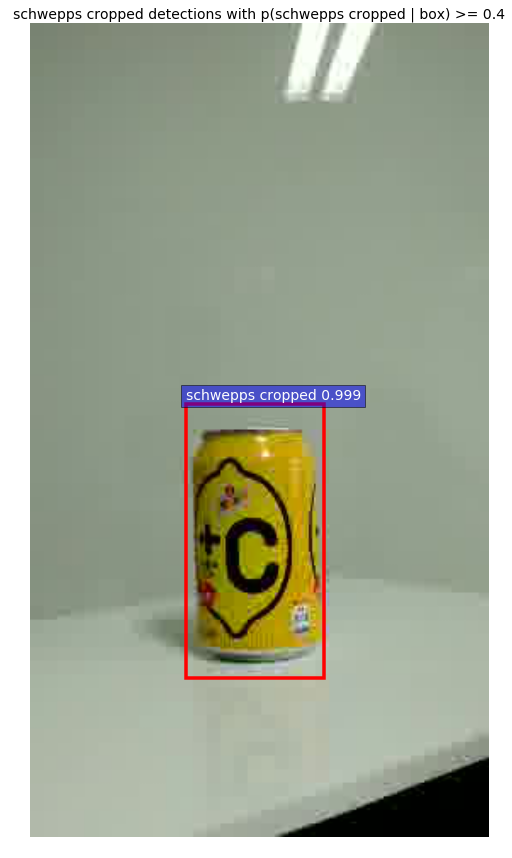

In [26]:
imgs = os.listdir(pics_dir)
imgs = ['schweppes080.jpg']
for img in imgs:
    print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    print 'Demo for data/demo/{}'.format(img)
    demo_test(net, img)

plt.show()